In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install foolbox
import foolbox 
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import torch.optim as optim
import math

     |████████████████████████████████| 1.7MB 7.5MB/s 
     |████████████████████████████████| 174kB 32.3MB/s 
     |████████████████████████████████| 61kB 9.4MB/s 
     |████████████████████████████████| 71kB 11.3MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device1=torch.device('cpu')
print(device)

cuda


In [ ]:
#Transforms
transformer=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.4845, 0.4903, 0.4508],[0.2135, 0.1970, 0.1911])
])

In [ ]:
train_set=torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/ucm_train', transform=transformer)
valid_set=torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/ucm_valid', transform=transformer)

batch_size_train=16
batch_size_valid=16
train_loader=DataLoader(train_set, batch_size=batch_size_train, shuffle=True)
valid_loader=DataLoader(valid_set, batch_size_valid, shuffle=True)

In [ ]:
def conv_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


def make_divisible(x, divisible_by=8):
    import numpy as np
    return int(np.ceil(x * 1. / divisible_by) * divisible_by)


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(inp * expand_ratio)
        self.use_res_connect = self.stride == 1 and inp == oup

        if expand_ratio == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV2(nn.Module):
    def __init__(self, n_class=21, input_size=224, width_mult=1.):
        super(MobileNetV2, self).__init__()
        block = InvertedResidual
        input_channel = 32
        last_channel = 1280
        interverted_residual_setting = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        # building first layer
        assert input_size % 32 == 0
        # input_channel = make_divisible(input_channel * width_mult)  # first channel is always 32!
        self.last_channel = make_divisible(last_channel * width_mult) if width_mult > 1.0 else last_channel
        self.features = [conv_bn(3, input_channel, 2)]
        # building inverted residual blocks
        for t, c, n, s in interverted_residual_setting:
            output_channel = make_divisible(c * width_mult) if t > 1 else c
            for i in range(n):
                if i == 0:
                    self.features.append(block(input_channel, output_channel, s, expand_ratio=t))
                else:
                    self.features.append(block(input_channel, output_channel, 1, expand_ratio=t))
                input_channel = output_channel
        # building last several layers
        self.features.append(conv_1x1_bn(input_channel, self.last_channel))
        # make it nn.Sequential
        self.features = nn.Sequential(*self.features)

        # building classifier
        self.classifier = nn.Linear(self.last_channel, n_class)

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.mean(3).mean(2)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

In [ ]:
model=MobileNetV2().to(device)

In [ ]:
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
criterion=nn.CrossEntropyLoss()

In [ ]:
train_count=len(train_set)
valid_count=len(valid_set)

In [ ]:
best_accuracy=0.0
num_epochs=100

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    valid_loss=0.0
    valid_accuracy=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count

    model.eval()
    
    for data, target in valid_loader:
      data = data.to(device)
      target = target.to(device)
      output = model(data)
      loss = criterion(output, target)
        
      # update-average-validation-loss 
      valid_loss += loss.item() * data.size(0)

      _,prediction=torch.max(output.data,1)
      valid_accuracy+=int(torch.sum(prediction==target.data))
      
    
    valid_accuracy=valid_accuracy/valid_count
    valid_loss=valid_loss/valid_count
       
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+ ' Valid Loss:'+str(valid_loss)+' Valid Accuracy:'+str(valid_accuracy))

    if(valid_accuracy>best_accuracy):
      torch.save(model.state_dict(), '/content/drive/MyDrive/mobilenetv2/model.pth')
      best_accuracy=valid_accuracy
      print("Best accuracy: ", best_accuracy)


In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/mobilenetv2/model.pth'))

<All keys matched successfully>

In [ ]:
# test-the-model
model.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        

    print('Test Accuracy of the model: {} '.format(correct / total))


Test Accuracy of the model: 0.8138424821002387 


In [ ]:
model=model.eval()

In [ ]:
bounds = (0, 1)
fmodel = foolbox.PyTorchModel(model, bounds=bounds)

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
dir='/content/drive/MyDrive/ucm_train'
classes = os.listdir(dir)
classes.sort()

0.8090692013502121


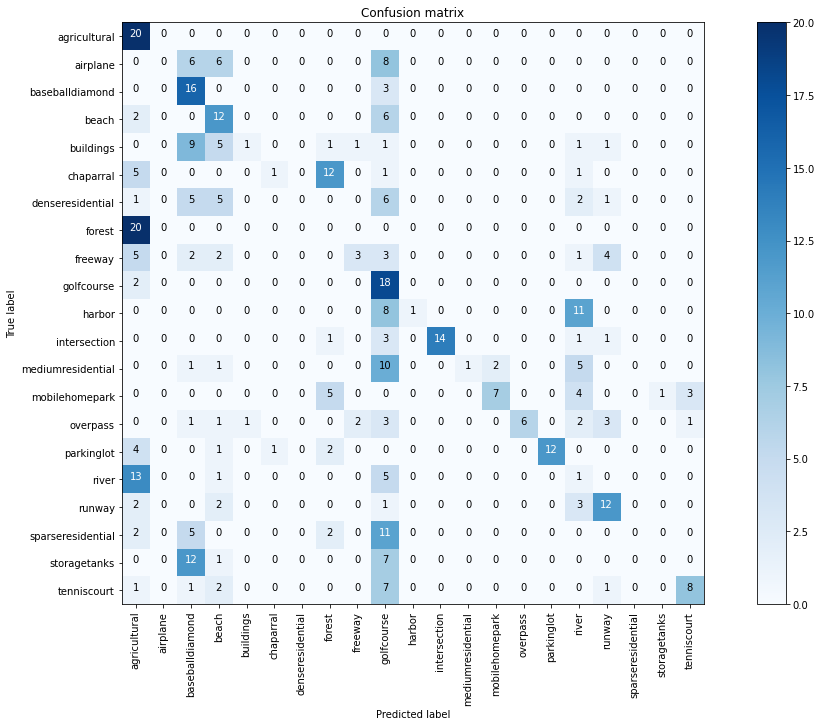

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2ContrastReductionAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

  

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.8186157494783401


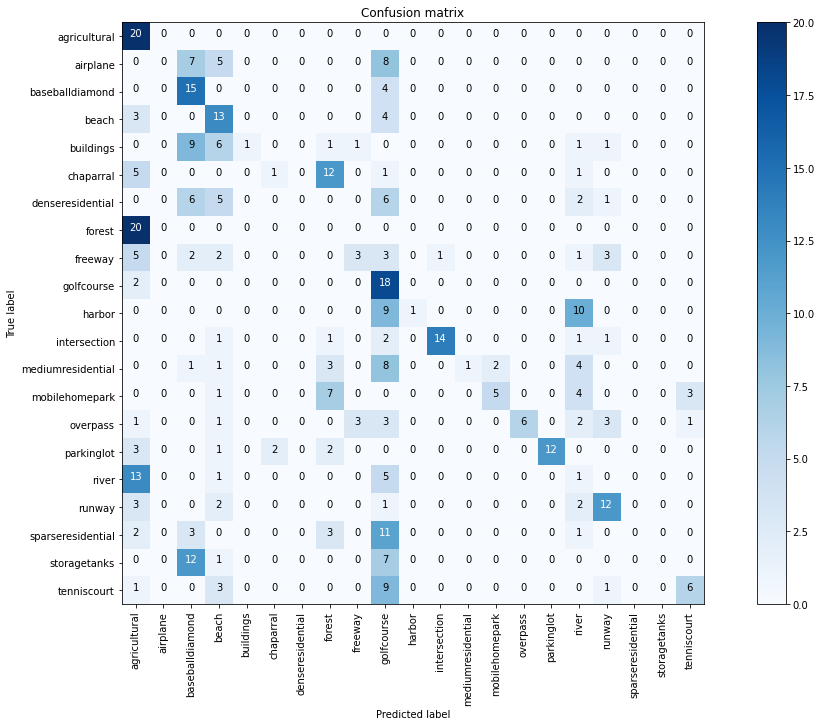

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.VirtualAdversarialAttack(steps=1)

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

  

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.8090692013502121


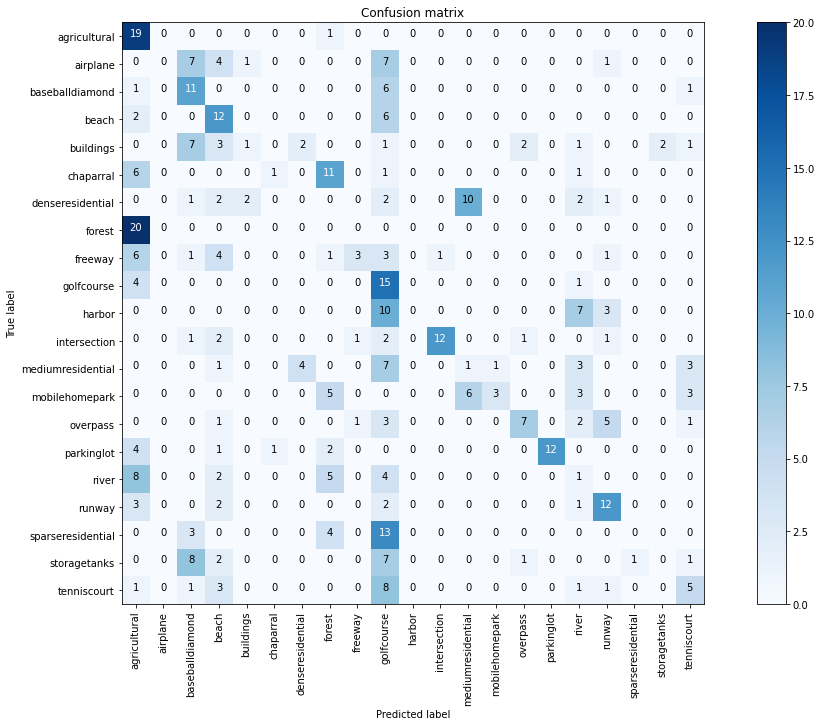

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.DDNAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

 

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.8257756531238556


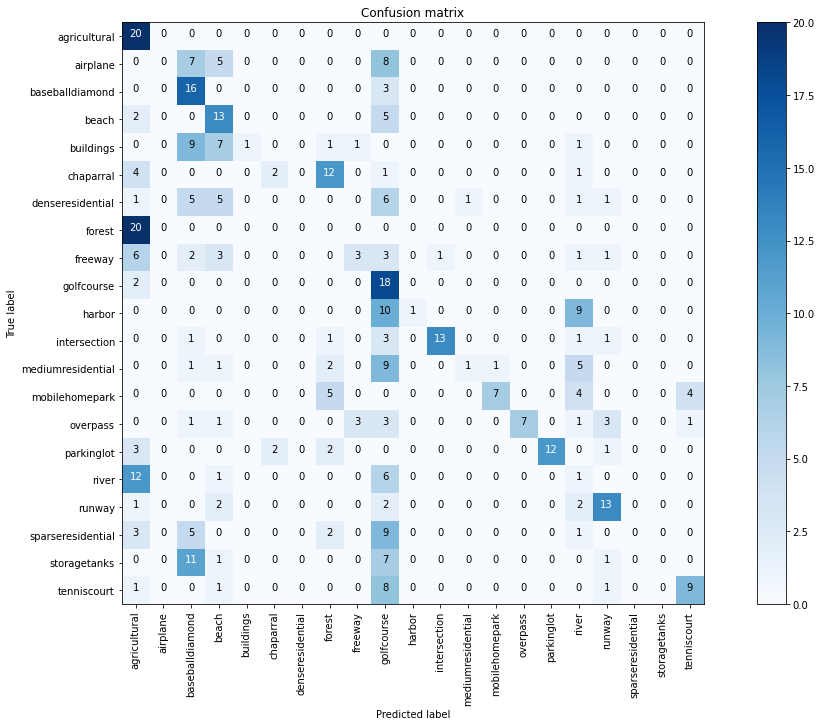

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2ProjectedGradientDescentAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

 
labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.8186157494783401


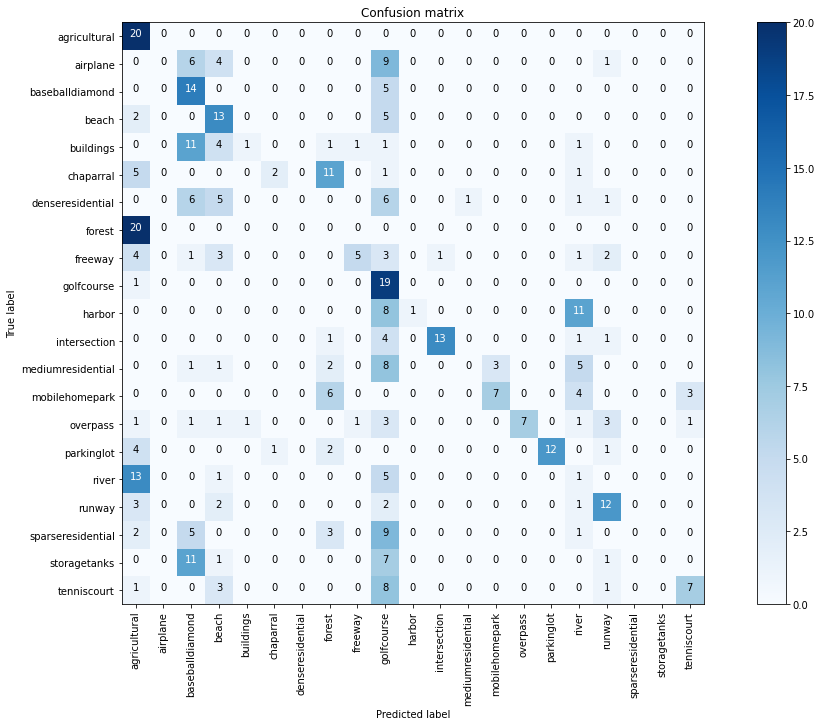

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.LinfProjectedGradientDescentAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

 

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.8257756531238556


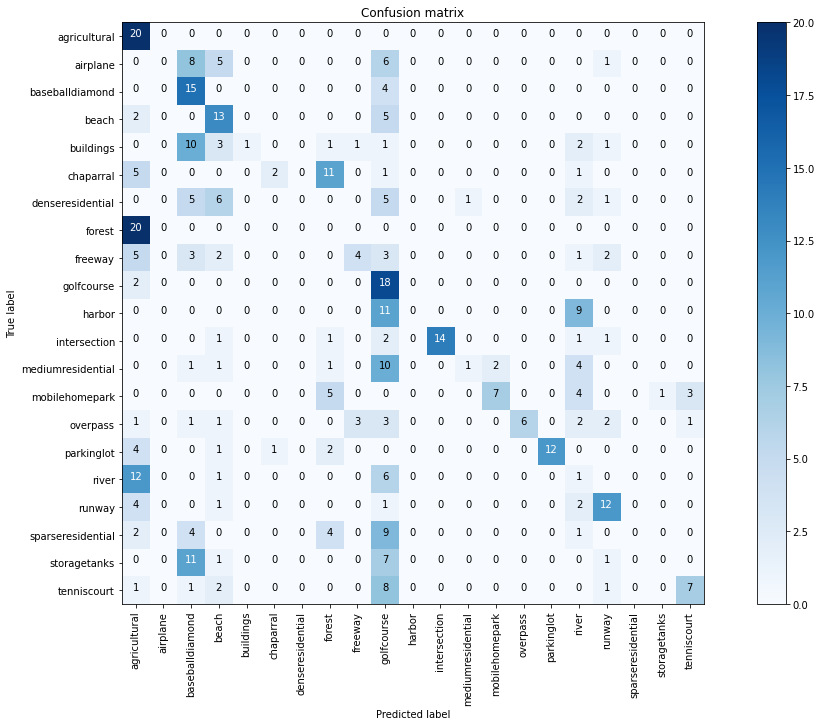

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2BasicIterativeAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

  

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.8138424754142761


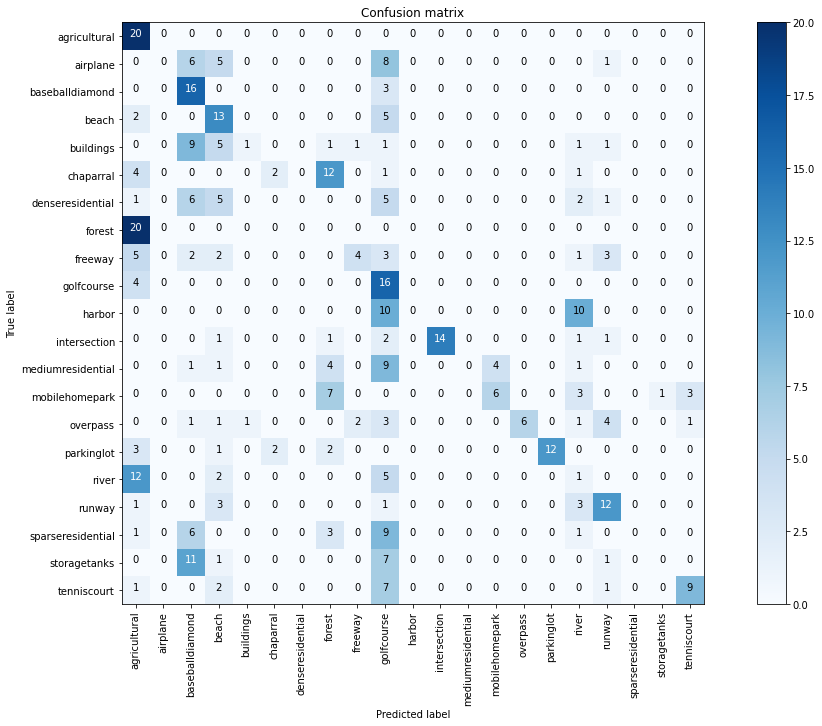

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.LinfBasicIterativeAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

  

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.8305489122867584


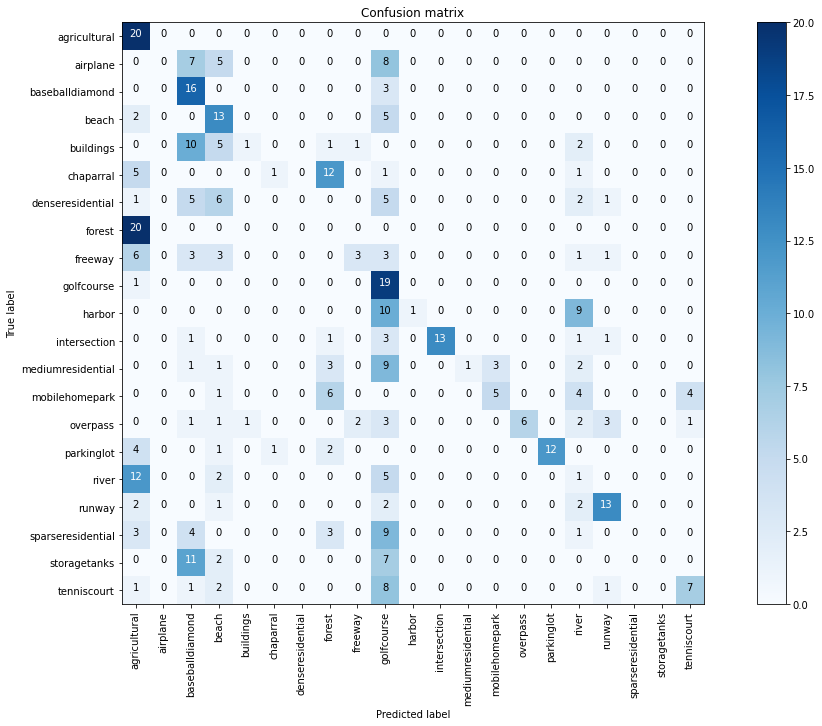

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2FastGradientAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

 
labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.8114558458328247


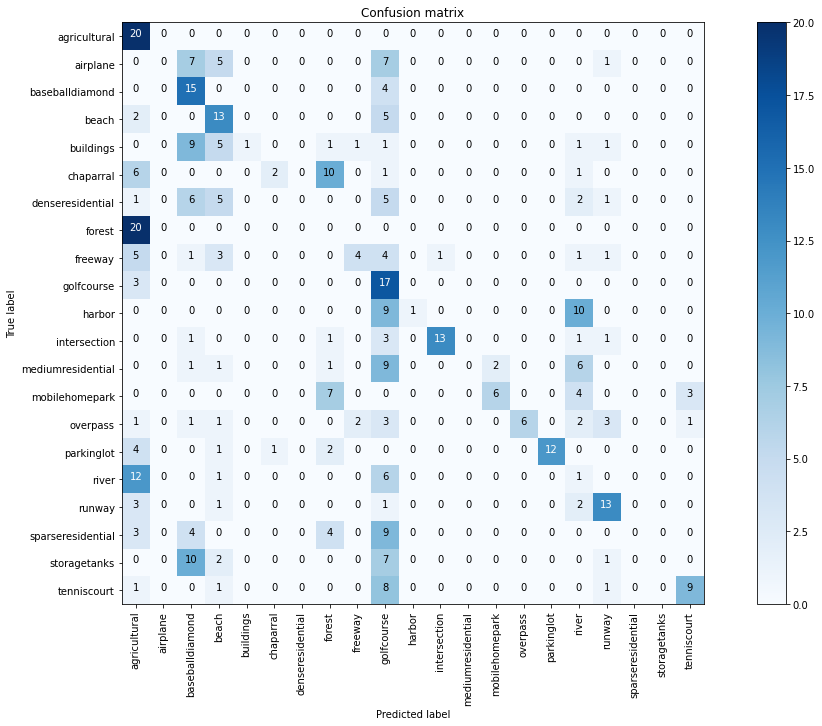

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.LinfFastGradientAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

  

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.7995226681232452


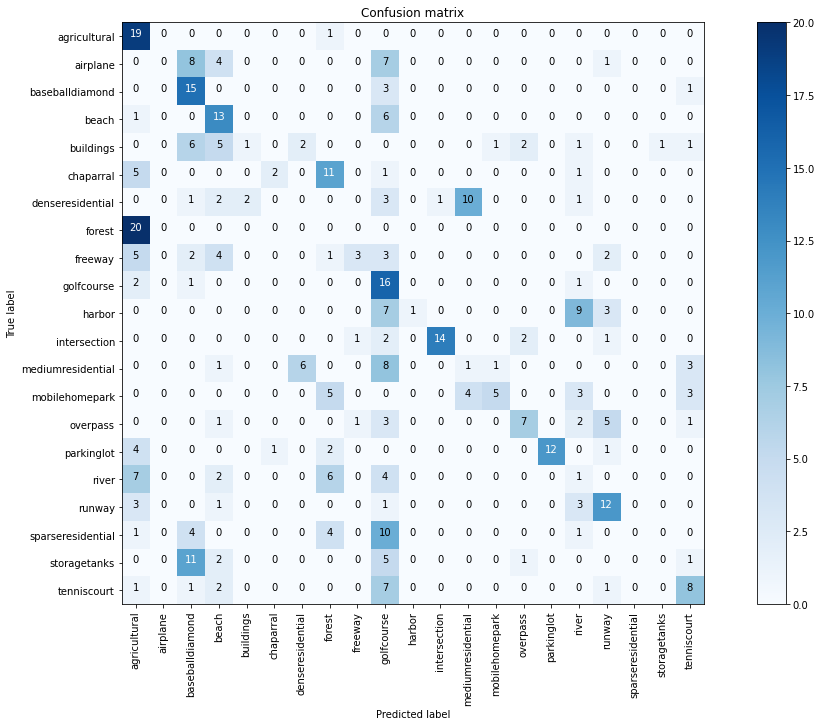

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2RepeatedAdditiveGaussianNoiseAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))



labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.8066825717687607


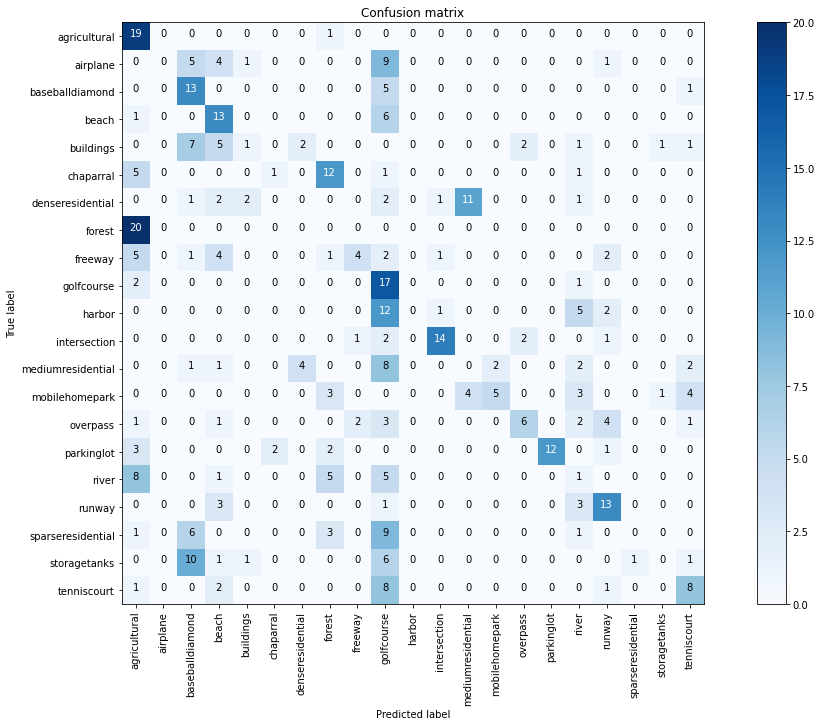

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2RepeatedAdditiveUniformNoiseAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

  

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.823389008641243


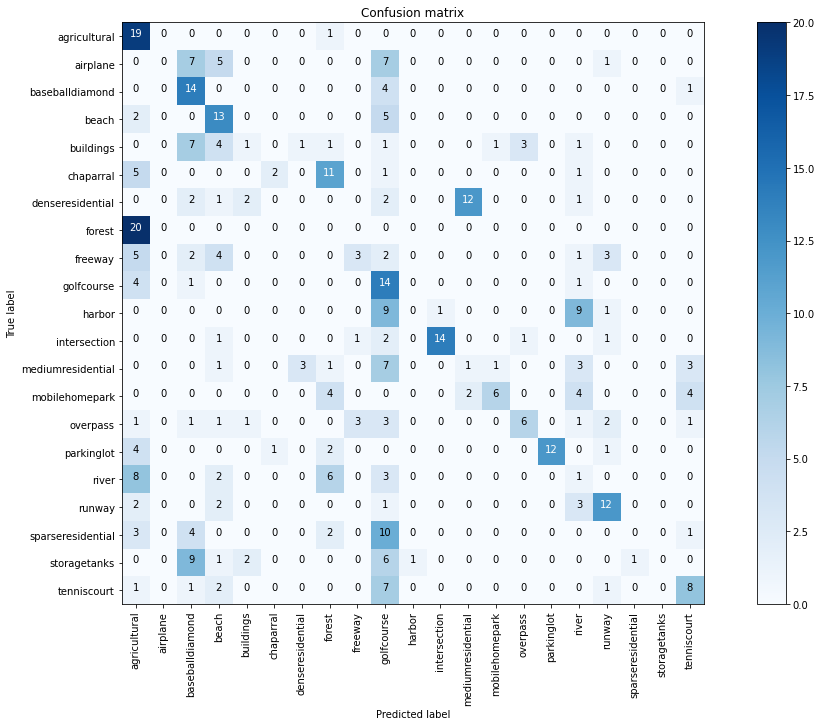

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2ClippingAwareRepeatedAdditiveGaussianNoiseAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

 
labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.8042959421873093


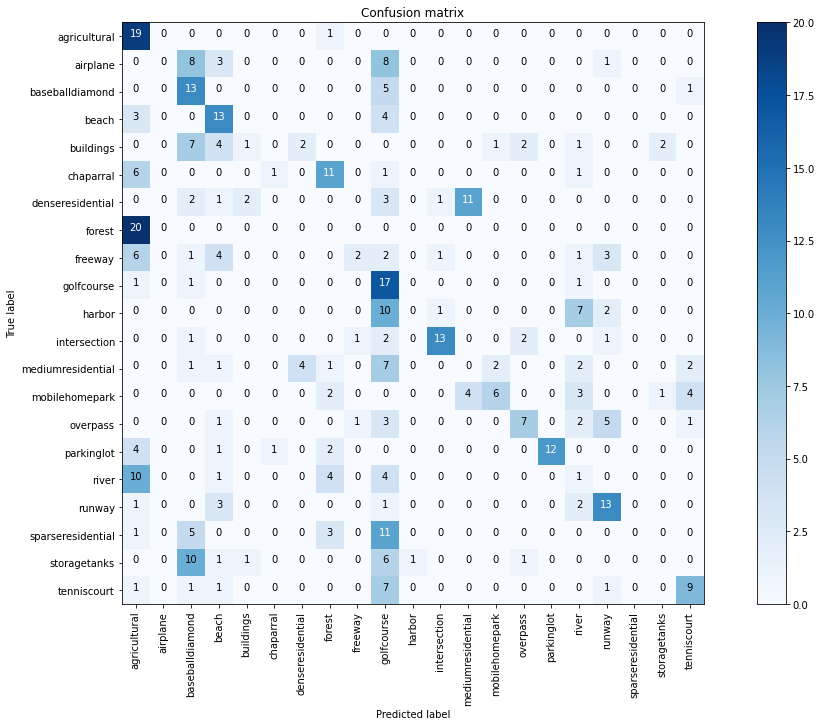

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2ClippingAwareRepeatedAdditiveUniformNoiseAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

 

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.8186157494783401


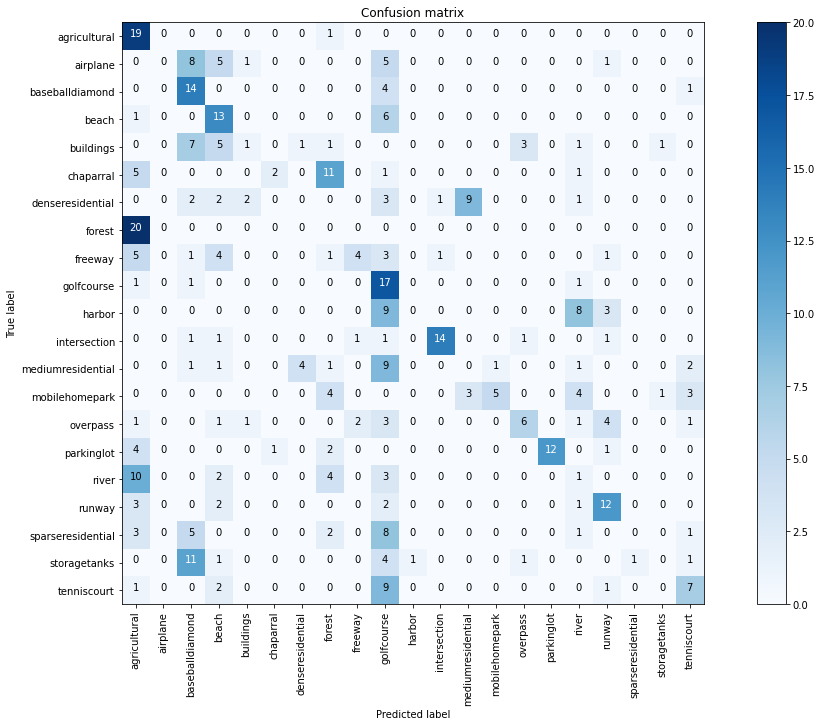

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.LinfRepeatedAdditiveUniformNoiseAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

  

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.8162291049957275


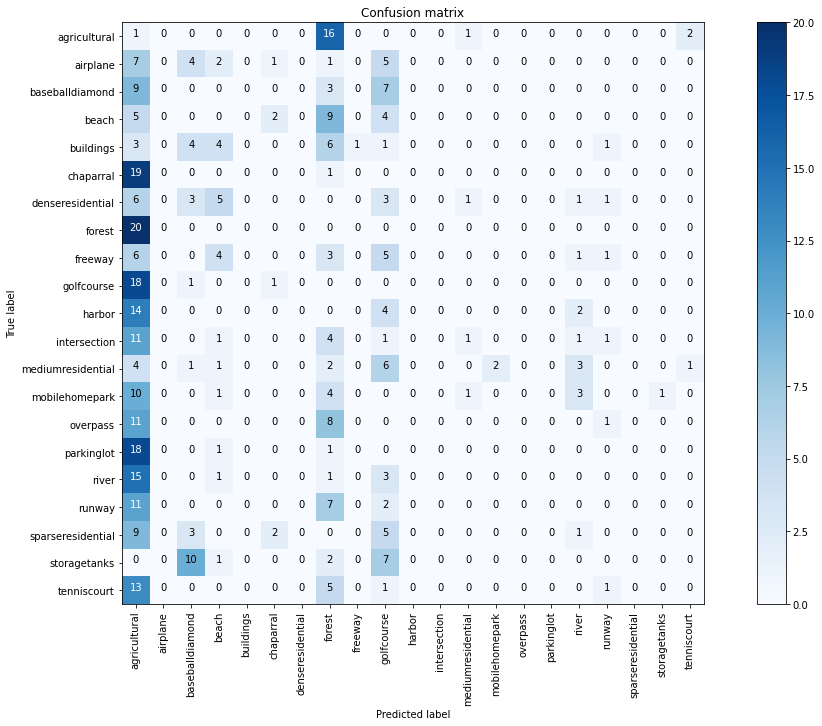

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.NewtonFoolAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

  

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.8090692013502121


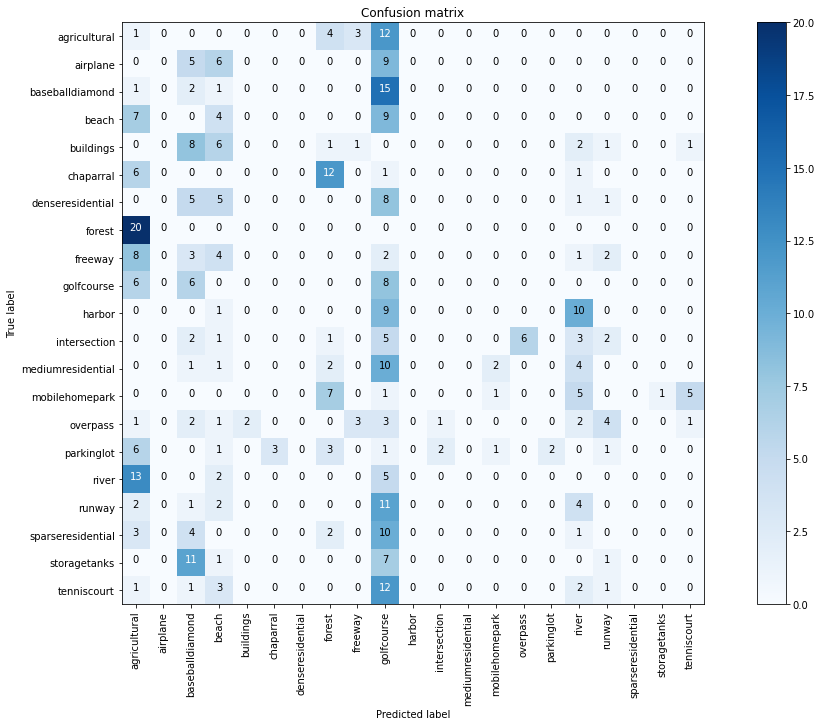

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.LinfDeepFoolAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))


labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.8186157494783401


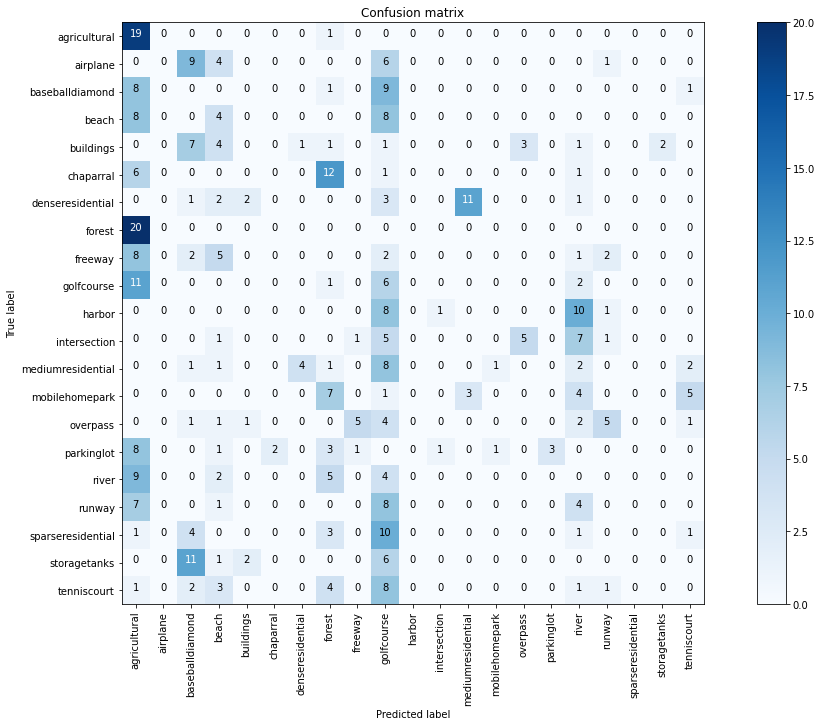

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.SaltAndPepperNoiseAttack()  

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))



labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.8162291049957275


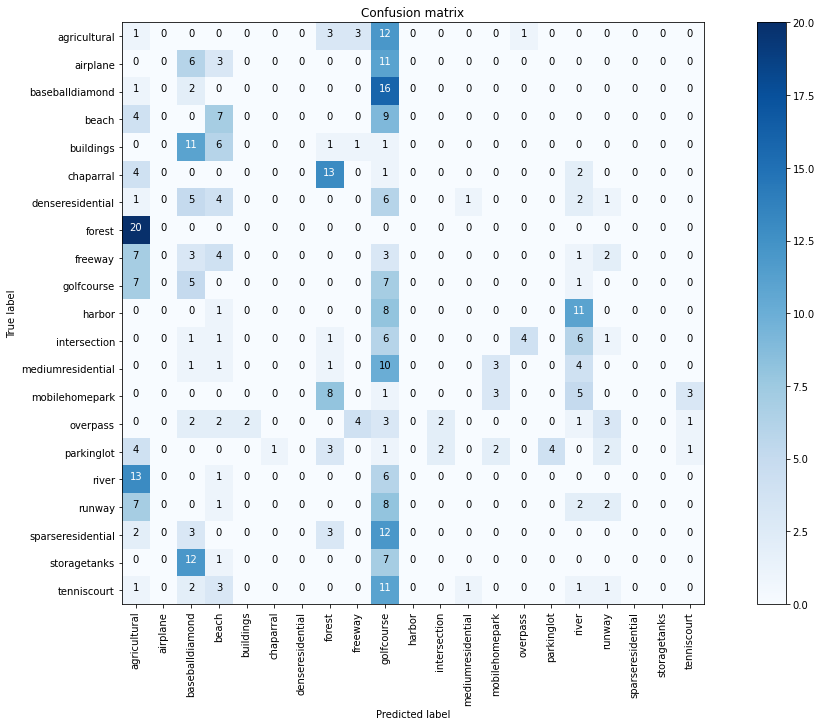

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2DeepFoolAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))


labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.8019092977046967


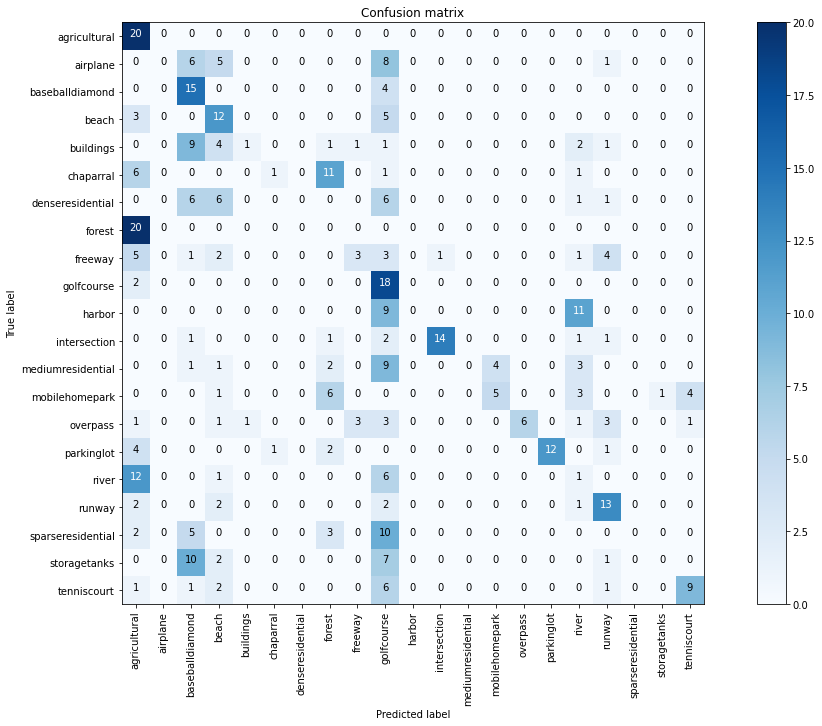

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2AdditiveGaussianNoiseAttack()
labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

  
labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.8090692013502121


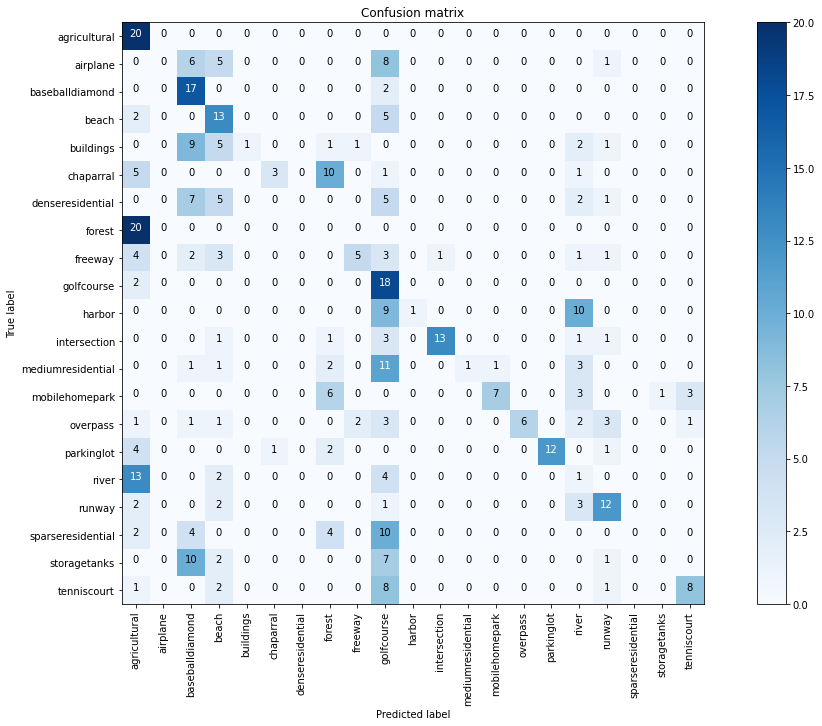

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2AdditiveUniformNoiseAttack()
labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

 
labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.8066825717687607


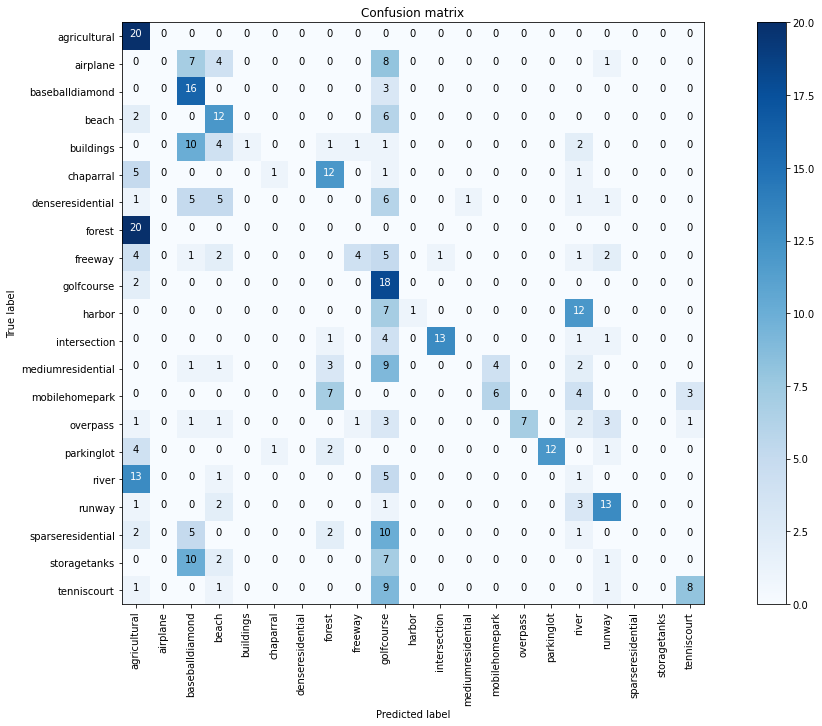

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2ClippingAwareAdditiveGaussianNoiseAttack()
labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

  

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.8042959421873093


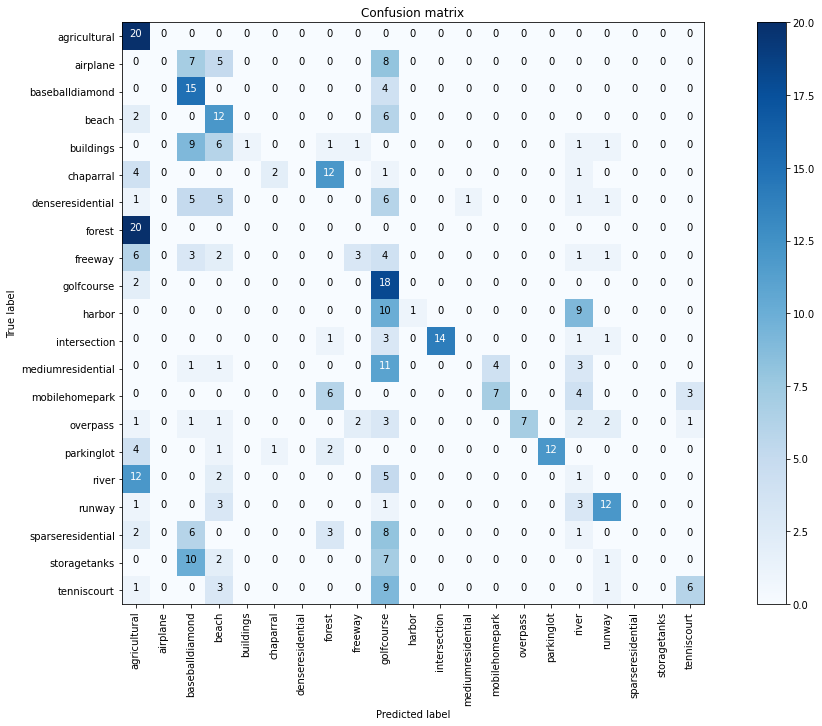

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2ClippingAwareAdditiveUniformNoiseAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

  

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.8114558458328247


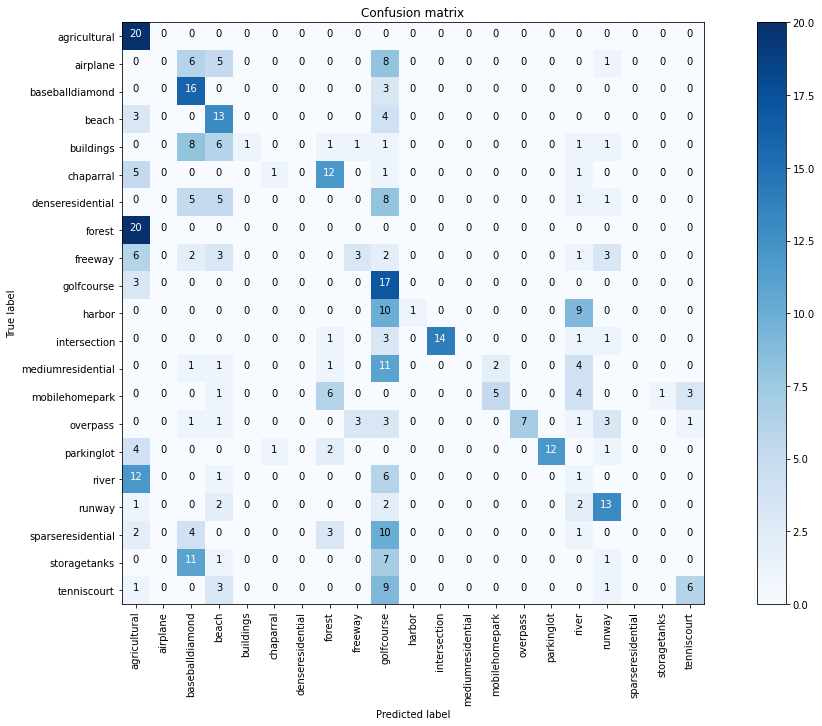

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.LinfAdditiveUniformNoiseAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))


labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.8210023790597916


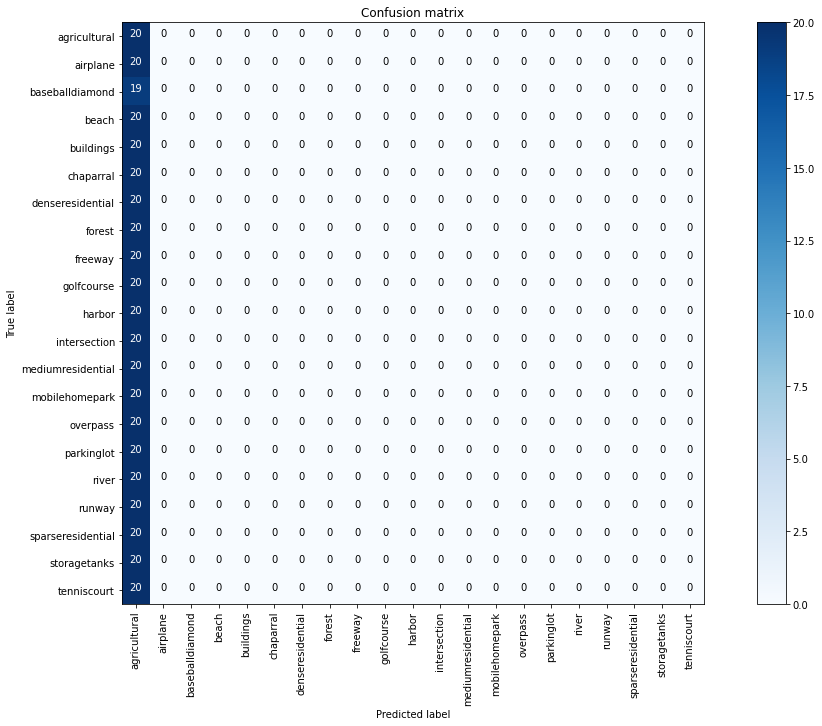

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2CarliniWagnerAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))


labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.8138424754142761


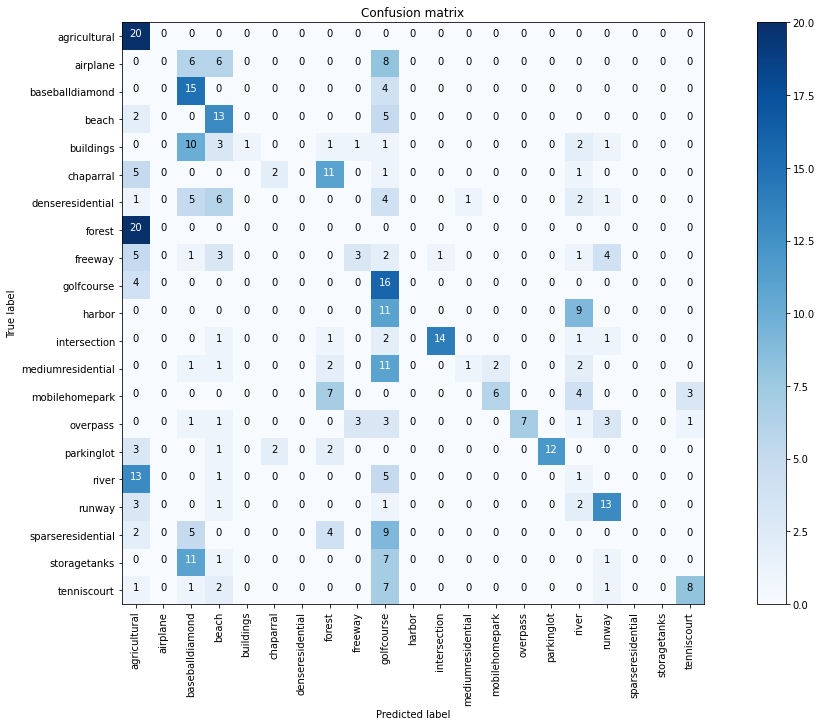

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.FGM()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.8138424754142761


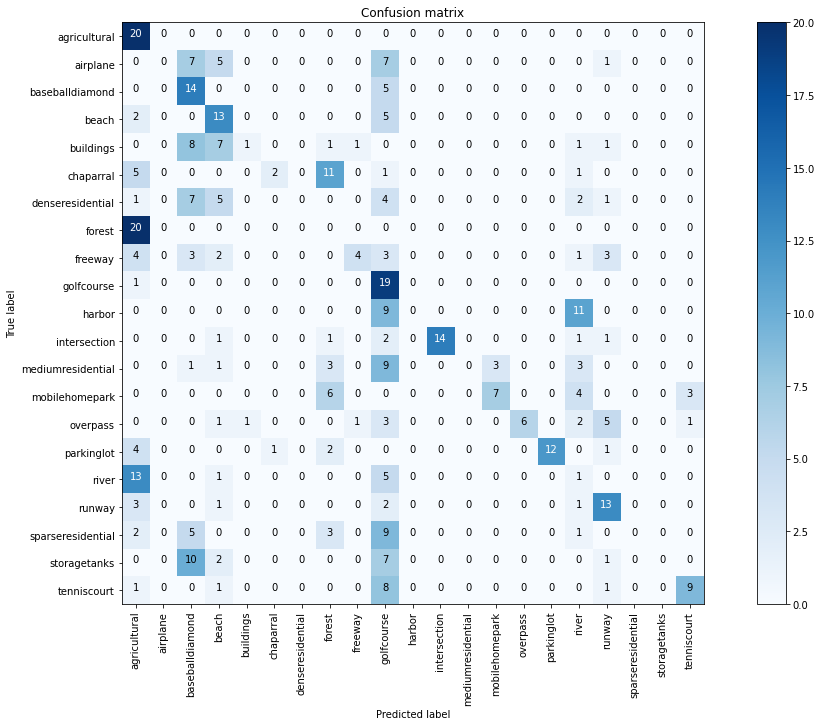

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.FGSM()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))


labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.8162291049957275


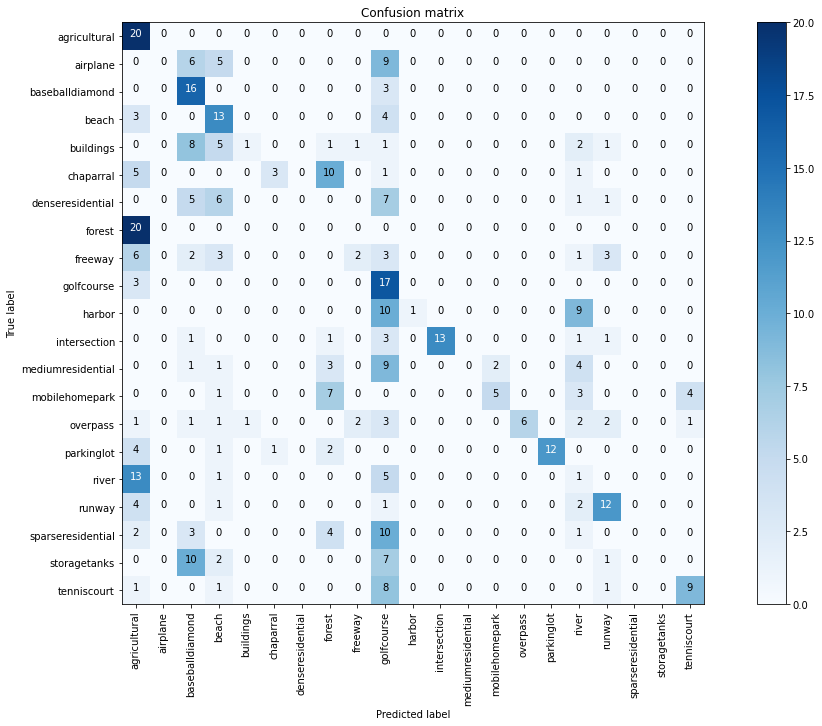

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2PGD()
labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

 

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.8090692013502121


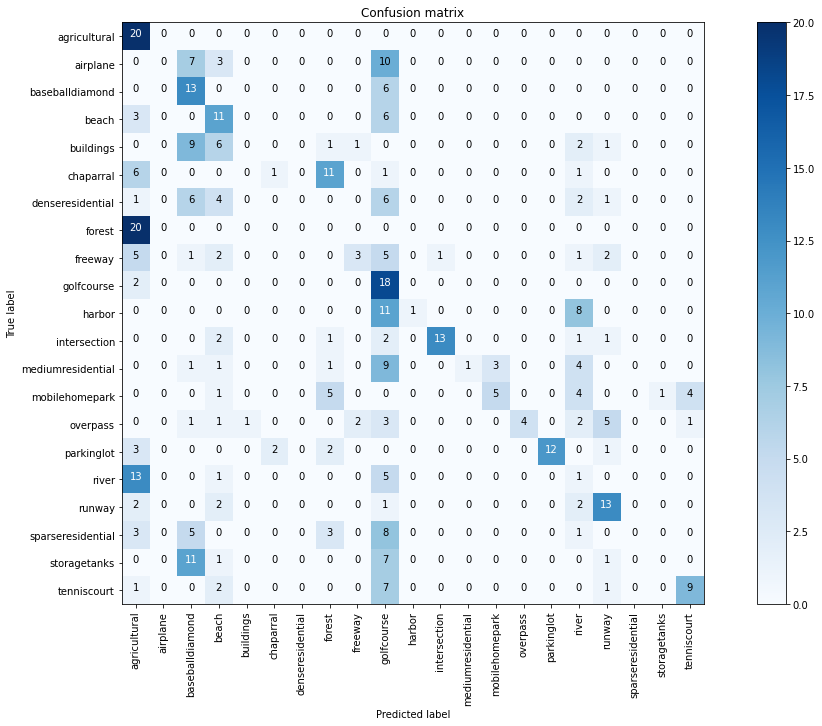

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.LinfPGD()
labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))



labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.8162291049957275


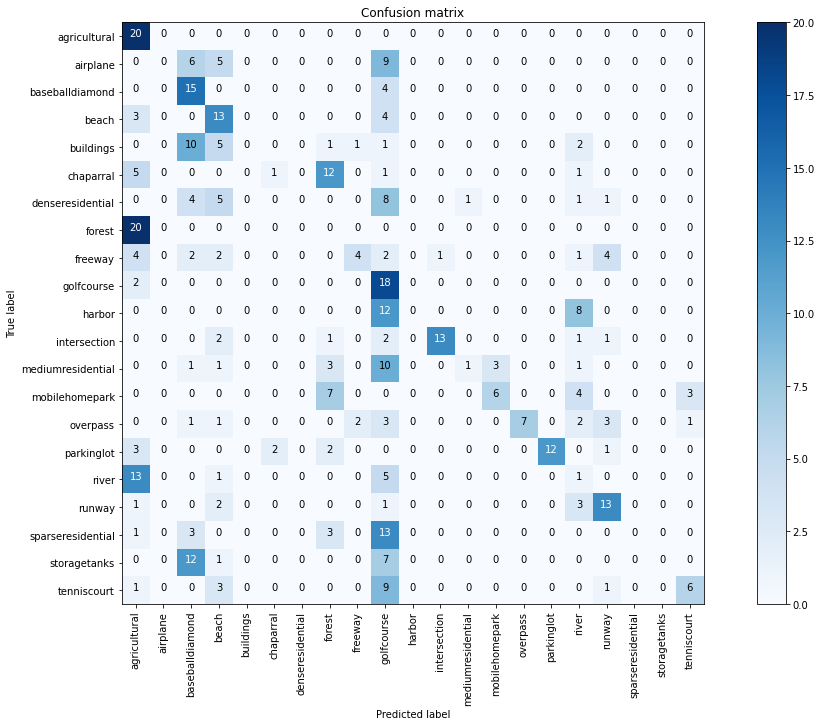

In [ ]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.PGD()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.0005)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))


labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)